# Developer tutorial: Nonstandard usage

Although Starsim is primarily intended as an agent-based disease model, due to its modular structure, it can be used for other applications as well. This tutorial describes how Starsim can be used (1) as a compartmental disease model, and (2) as a general-purpose agent-based model.

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/dev_tut_nonstandard.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Fdev_tut_nonstandard.ipynb).
    
</div>

## Compartmental modeling

Much of Starsim's power comes from how it handles agents. However, agent-based modeling may be too slow or too complex for some problems. While in many cases it probably makes more sense to do compartmental disease modeling in another framework (such as [Atomica](https://atomica.tools/)), it is also possible to do it within Starsim, taking advantage of features such as demographics, time units, etc. This is especially useful for a multi-disease simulation where some diseases need the detail and flexibility of an ABM, while others can be modeled more simply (and faster) as compartmental models.

### Setting up the model

Here we will define a simple compartmental susceptible-infectious-susceptible (SIS) model. The model definition here is quite similar to the agent-based implementation in Starsim's [SIR module](https://github.com/starsimhub/starsim/blob/main/starsim/diseases/sir.py); differences are noted in comments. Note that the model runs extremely fast, since a three-state compartmental model (susceptible, infecious, and immunity) runs as fast as an agent-based model with three agents!

Initializing sim with 10000 agents
  Running 2000.0 ( 0/1001) (0.00 s)  ———————————————————— 0%
  Running 2010.0 (100/1001) (0.01 s)  ••—————————————————— 10%
  Running 2020.0 (200/1001) (0.03 s)  ••••———————————————— 20%
  Running 2030.0 (300/1001) (0.04 s)  ••••••—————————————— 30%
  Running 2040.0 (400/1001) (0.05 s)  ••••••••———————————— 40%
  Running 2050.0 (500/1001) (0.07 s)  ••••••••••—————————— 50%
  Running 2060.0 (600/1001) (0.08 s)  ••••••••••••———————— 60%
  Running 2070.0 (700/1001) (0.09 s)  ••••••••••••••—————— 70%
  Running 2080.0 (800/1001) (0.11 s)  ••••••••••••••••———— 80%
  Running 2090.0 (900/1001) (0.12 s)  ••••••••••••••••••—— 90%
  Running 2100.0 (1000/1001) (0.13 s)  •••••••••••••••••••• 100%



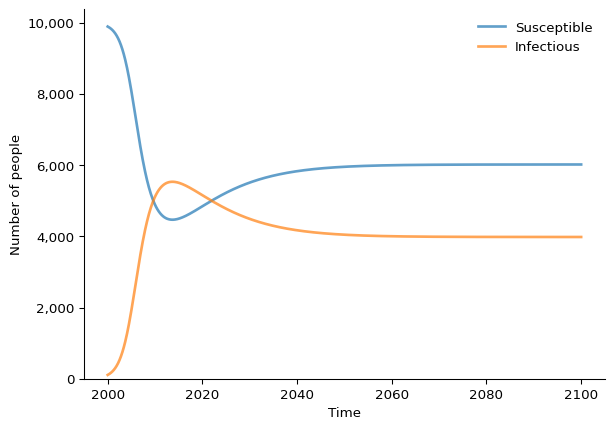

In [1]:
"""
Example compartmental SIS model for Starsim
"""

import starsim as ss
import sciris as sc
import matplotlib.pyplot as plt


class CompartmentalSIS(ss.Module): # We don't need the extra functionality of the Infection class, so just inherit from Module
    def __init__(self, pars=None, *args, **kwargs):
        super().__init__()
        self.define_pars(
            beta = ss.rate(0.8), # Leverage Starsim's automatic time unit handling
            init_prev = 0.01, # NB: this is a scalar, rather than a distribution for an ABM
            recovery = ss.rate(0.1), # Also not a distribution
            waning = ss.rate(0.05),
            imm_boost = 1.0,
            use_immunity = True,
        )
        self.update_pars(pars=pars, *args, **kwargs)
        
        # Don't need to define states; just use scalars
        self.N = 0
        self.S = 0
        self.I = 0
        self.immunity = 0
        return
    
    def init_post(self):
        """ Finish initialization """
        super().init_post()
        self.N = len(self.sim.people) # Assumes a static population; could also use a dynamic population size
        i0 = self.pars.init_prev
        self.S = self.N*(1-i0)
        self.I = self.N*i0
        self.immunity = i0
        return
        
    @property
    def rel_sus(self):
        return 1 - self.immunity
    
    def step(self):
        """ Carry out disease transmission logic """
        self.immunity *= (1 - self.pars.waning) # Update immunity from waning
        rel_sus = self.rel_sus if self.pars.use_immunity else 1.0
        infected = (self.S*self.I/self.N)*self.pars.beta*rel_sus # Replaces Infection.infect()
        recovered = self.I*self.pars.recovery # Replaces setting a time to recovery and checking that time
        net = infected - recovered # Net change in number infectious
        self.S -= net
        self.I += net
        self.immunity += infected/self.N*self.pars.imm_boost # Update immunity from new infections
        return
    
    def init_results(self):
        """ Initialize results """
        super().init_results()
        self.define_results(
            ss.Result('S', label='Susceptible'),
            ss.Result('I', label='Infectious'),
        )
        return

    def update_results(self):
        """ Store the current state """
        super().update_results()
        self.results['S'][self.ti] = self.S
        self.results['I'][self.ti] = self.I
        return 

    def plot(self):
        """ Default plot for SIS model """
        fig = plt.figure()
        res = self.results
        kw = dict(lw=2, alpha=0.7)
        for rkey in ['S', 'I']:
            plt.plot(res.timevec, res[rkey], label=res[rkey].label, **kw)
        plt.legend(frameon=False)
        plt.xlabel('Time')
        plt.ylabel('Number of people')
        plt.ylim(bottom=0)
        sc.boxoff()
        sc.commaticks() 
        plt.show()      
        return
    

# Run the compartmental simulation (csim)
csim = ss.Sim(diseases=CompartmentalSIS(), dur=100, dt=0.1, verbose=0.01)
csim.run()

# Plot the results
csim.diseases.compartmentalsis.plot()

Let's compare to our standard agent-based SIS model with similar parameters:

Initializing sim with 10000 agents
  Running 2000.0 ( 0/1001) (0.00 s)  ———————————————————— 0%


  Running 2010.0 (100/1001) (0.36 s)  ••—————————————————— 10%


  Running 2020.0 (200/1001) (0.73 s)  ••••———————————————— 20%


  Running 2030.0 (300/1001) (1.11 s)  ••••••—————————————— 30%


  Running 2040.0 (400/1001) (1.47 s)  ••••••••———————————— 40%


  Running 2050.0 (500/1001) (1.84 s)  ••••••••••—————————— 50%


  Running 2060.0 (600/1001) (2.22 s)  ••••••••••••———————— 60%


  Running 2070.0 (700/1001) (2.59 s)  ••••••••••••••—————— 70%


  Running 2080.0 (800/1001) (2.95 s)  ••••••••••••••••———— 80%


  Running 2090.0 (900/1001) (3.32 s)  ••••••••••••••••••—— 90%


  Running 2100.0 (1000/1001) (3.69 s)  •••••••••••••••••••• 100%

Figure(672x480)


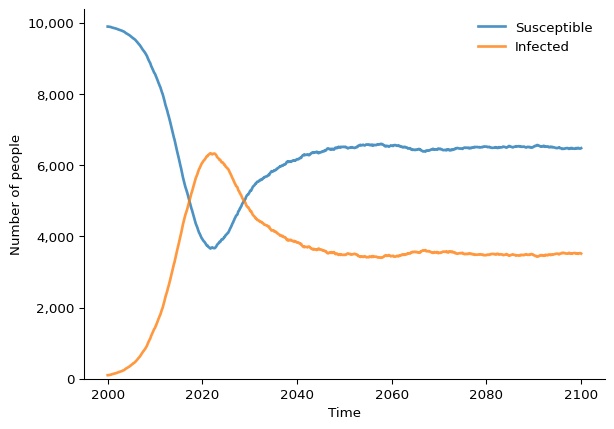

In [2]:
import starsim as ss

# Run the model
abm = ss.Sim(diseases=ss.SIS(beta=0.03), networks='random', dur=100, dt=0.1, verbose=0.01)
abm.run()

# Plot the results
abm.diseases.sis.plot()

The results are broadly similar, although there are differences due to the network transmission, duration of infection, etc. Note that the compartmental version runs 20 times faster than the agent-based version. Does this mean that compartmental models are better than agent-based models? If all you want to simulate is a simple SIS model, then ... the answer is probably yes!

## Mesa: Wealth model

This example illustrates a simple "weath model", in which each agent starts with a single unit of wealth, and on each timestep, every agent with more than zero wealth gives one unit of wealth to another agent.

This tutorial is adapted from the following example:

https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html

### Setting up the model

We could define the wealth model as any type of module, since they all can store states and update them. Here we will define wealth as a subclass of `ss.Intervention` (though it could equally well be a subclass of `ss.Demographics` or even `ss.Disease`, if you are so inclined). All we need to do is update the `wealth` state (which we can store inside the "intervention"), and we can also use this class to track the wealth distribution over time and plot it. The full model looks like this:

Initializing sim with 100 agents
  Running 0.0 ( 0/101) (0.00 s)  ———————————————————— 1%
  Running 10.0 (10/101) (0.00 s)  ••—————————————————— 11%
  Running 20.0 (20/101) (0.00 s)  ••••———————————————— 21%
  Running 30.0 (30/101) (0.00 s)  ••••••—————————————— 31%
  Running 40.0 (40/101) (0.01 s)  ••••••••———————————— 41%
  Running 50.0 (50/101) (0.01 s)  ••••••••••—————————— 50%
  Running 60.0 (60/101) (0.01 s)  ••••••••••••———————— 60%
  Running 70.0 (70/101) (0.01 s)  ••••••••••••••—————— 70%
  Running 80.0 (80/101) (0.01 s)  ••••••••••••••••———— 80%
  Running 90.0 (90/101) (0.01 s)  ••••••••••••••••••—— 90%
  Running 100.0 (100/101) (0.01 s)  •••••••••••••••••••• 100%



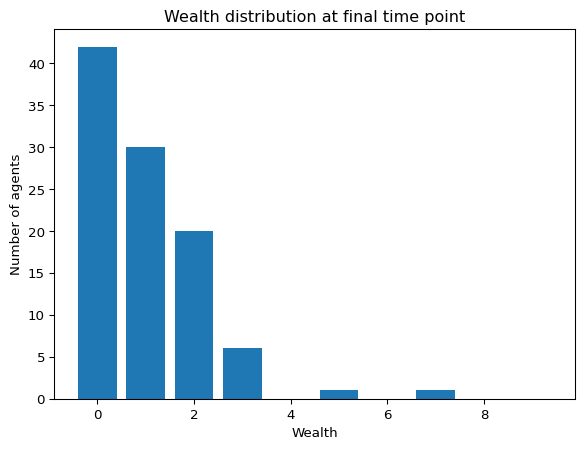

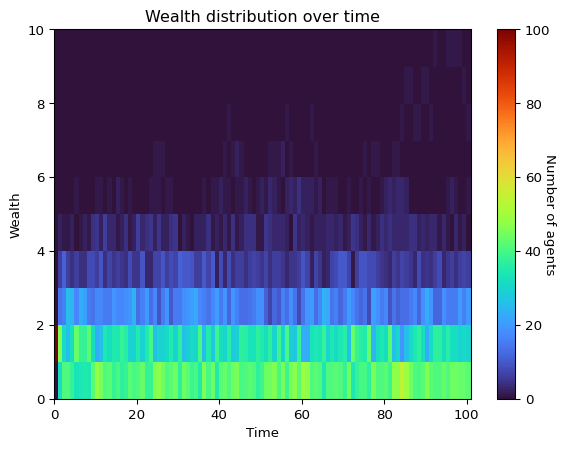

In [3]:
"""
Define the classic agent-based "wealth model" in Starsim
"""

# Imports
import numpy as np
import starsim as ss
import matplotlib.pyplot as plt

# Define the model
class WealthModel(ss.Module):
    """ A simple wealth transfer model"""
    
    def init_post(self, bins=10):
        """ Define custom model attributes """
        super().init_post()
        self.npts = len(self.sim) # Number of timepoints
        self.n_agents = len(sim.people) # Number of agents
        self.wealth = np.ones(self.n_agents) # Initial wealth of each agent
        self.bins = np.arange(bins+1) # Bins used for plotting
        self.wealth_dist = np.zeros((self.npts, len(self.bins)-1)) # Wealth distribution over time
        return
        
    def step(self):
        """ Transfer wealth between agents -- core model logic """
        self.wealth_hist() # Store the wealth at this time point
        givers = self.wealth > 0 # People need wealth to be givers
        receivers = np.random.choice(self.sim.people.uid, size=givers.sum()) # Anyone can be a receiver
        self.wealth[givers] -= 1 # Givers are unique, so can use vectorized version
        for receive in receivers: # Vectorized version is: np.add.at(sim.people.wealth.raw, receivers, 1)
            self.wealth[receive] += 1
        return
    
    def wealth_hist(self):
        """ Calculate the wealth histogram """
        ti = self.sim.ti # Current timestep
        self.wealth_dist[ti,:], _ = np.histogram(self.wealth, bins=self.bins)
        return
    
    def plot(self):
        """ Plot a 2D histogram of the final wealth distribution """
        plt.figure()
        plt.bar(self.bins[:-1], self.wealth_dist[-1,:])
        plt.title('Wealth distribution at final time point')
        plt.xlabel('Wealth')
        plt.ylabel('Number of agents')
        plt.show()
        return
    
    def plot3d(self):
        """ Plot a 3D heatmap of the wealth distribution over time """
        plt.figure()
        plt.pcolor(self.wealth_dist.T, cmap='turbo')
        plt.title('Wealth distribution over time')
        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.colorbar().set_label('Number of agents', rotation=270)
        plt.show()
        return

# Create sim inputs, including the wealth model
wealth = WealthModel()
pars = dict(
    n_agents = 100, # Number of agents
    start = 0,
    stop = 100,
    demographics = wealth,
)

# Run the model
sim = ss.Sim(pars, copy_inputs=False) # copy_inputs=False lets us reuse the "wealth" object from above
sim.run()

# Plot the results
wealth.plot()
wealth.plot3d()

### Comparison with Mesa

While the implementation in Starsim is similar to Mesa, there are a couple key differences:

- Because Starsim's people object is vectorized, the wealth definition and update is vectorized as well.
- Both Mesa and Starsim versions of the model are quite simple, but there is a little less boilerplate in the Starsim version.